In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps
                                        
%matplotlib inline

In [ ]:
from sklearn import datasets
import numpy as np
from statistics import mean

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models, Model 
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import categorical_crossentropy, mse
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import backend as K

### Create train and test sets from  Iris dataset

In [4]:
iris = datasets.load_iris()
X = iris.data[:, :].astype('float32') 
y = iris.target.astype('float32')
y_onehot = to_categorical(y)

In [5]:
X.shape

(150, 4)

In [6]:
y[0:5]

array([0., 0., 0., 0., 0.], dtype=float32)

In [7]:
y_onehot[0:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [8]:
x_train = X[:40]
y_train = list(y[:40])
y_train_onehot = y_onehot[:40]

for i in range(1,3):
    x_train = np.vstack((x_train, X[i*50:(i*50)+40]))
    y_train = y_train + list(y[i*50:(i*50)+40])
    y_train_onehot = np.vstack((y_train_onehot, y_onehot[i*50:(i*50)+40]))
print(x_train.shape, y_train_onehot.shape)

(120, 4) (120, 3)


In [9]:
x_test = X[40:50]
y_test = list(y[40:50])
y_test_onehot = y_onehot[40:50]

for i in range(1,3):
    x_test = np.vstack((x_test, X[(i*50)+40:(i*50)+40+10]))
    y_test = y_test + list(y[(i*50)+40:(i*50)+40+10])
    y_test_onehot = np.vstack((y_test_onehot, y_onehot[(i*50)+40:(i*50)+40+10]))
y_test = np.asarray(y_test)
print(x_test.shape, y_test.shape, y_test_onehot.shape)

(30, 4) (30,) (30, 3)


### Networks and callbacks

In [10]:
input = layers.Input(shape=(4,), name='myInput')

In [11]:
batch_size = 15

In [12]:
#The selector layer that combines the expert and gate outputs. It is a non trainable layer
class selector_expectation(Layer):
    def __init__(self,num_experts, **kwargs):
        self.num_experts = num_experts
        super(selector_expectation,self).__init__(**kwargs)

    def build(self,input_shape):
        super(selector_expectation, self).build(input_shape)
        
    def call(self,input):

        x = input[0]
        p = input[1]
#         tf.print(K.shape(p))
        x = K.reshape(x,(batch_size, self.num_experts, 3))
#         tf.print('x:',x)
#         tf.print('p:',p)
        #Expected sum of the outputs of the experts
        output = K.sum(K.repeat_elements(K.reshape(p,(batch_size,self.num_experts,1)), rep=3,axis=2) * x, axis=1) 
#         tf.print('o:', output)
        return output
        
    def compute_output_shape(self,input_shape):
        return (input_shape[0],1,input_shape[-1])

    def get_config(self):
        return super(selector_expectation,self).get_config()


In [13]:
#Expert network
def expert_layers(input, output, name):
    x = layers.Dense(1000, activation='relu')(input)
    x = layers.Dense(500, activation='relu')(x)
    x = layers.Dense(300,activation='relu')(x)
    x = layers.Dense(output, activation='softmax',name=name)(x)
    return x

In [14]:
#Gate network (Similar to the expert layer)
def gate_layers(input, output, name):
    x = layers.Dense(1000, activation='relu')(input)
    x = layers.Dense(500, activation='relu')(x)
    x = layers.Dense(300,activation='relu')(x)
    x = layers.Dense(output, activation='softmax',name=name)(x)
    return x

In [15]:
# Custom Model to intercept training to analyze the gradients during training
class CustomModel(Model):
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred)
            
        # Get the trainable weights
        trainable_gate_wts = [self.get_layer('dense').trainable_weights[0]]
        for i in range(1, 3):           
            trainable_gate_wts.append(self.get_layer('dense_'+str(i)).trainable_weights[0])
        trainable_gate_wts.append(self.get_layer('gate_layer').trainable_weights[0])
        
        gate_gradients = tape.gradient(loss, trainable_gate_wts)
        mean_abs_gradients = [ K.mean(K.abs(x)) for x in gate_gradients ]
        
        tf.print('\n', 'gate gradients:', mean_abs_gradients)
                   
        return super(CustomModel, self).train_step(data)

In [16]:
#Callback to track the loss and mean absolute activations of each expert during training
# and track the mean absolute activations of the gate network during training
class AnalysisCallback(Callback):
    expert_loss_0 = []
    expert_loss_1 = []
    expert_loss_2 = []
    expert_mean_abs_act_0 = []
    expert_mean_abs_act_1 = []
    expert_mean_abs_act_2 = []
    gate_mean_abs_act = []
    
    def __init__(self, num_experts):
        self.num_experts = num_experts
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if self.num_experts >= 1:
            pred = self.model.get_layer('dense_3')(x_test[:15])
            pred = self.model.get_layer('dense_4')(pred)
            pred = self.model.get_layer('dense_5')(pred)
            pred = self.model.get_layer('expert_0')(pred)
            loss = K.mean(categorical_crossentropy(y_test_onehot[:15], pred))
            self.expert_loss_0.append(loss)
            self.expert_mean_abs_act_0.append(K.mean(K.abs(self.model.get_layer('dense_5').trainable_weights[0])))
       
        if self.num_experts >= 2:
            pred = self.model.get_layer('dense_6')(x_test[:15])
            pred = self.model.get_layer('dense_7')(pred)
            pred = self.model.get_layer('dense_8')(pred)
            pred = self.model.get_layer('expert_1')(pred)
            loss = K.mean(categorical_crossentropy(y_test_onehot[:15], pred))
            self.expert_loss_1.append(loss)
            self.expert_mean_abs_act_1.append(K.mean(K.abs(self.model.get_layer('dense_8').trainable_weights[0])))

        if self.num_experts >= 3:
            pred = self.model.get_layer('dense_9')(x_test[:15])
            pred = self.model.get_layer('dense_10')(pred)
            pred = self.model.get_layer('dense_11')(pred)
            pred = self.model.get_layer('expert_2')(pred)
            loss = K.mean(categorical_crossentropy(y_test_onehot[:15], pred))
            self.expert_loss_2.append(loss)
            self.expert_mean_abs_act_2.append(K.mean(K.abs(self.model.get_layer('dense_11').trainable_weights[0])))

        self.gate_mean_abs_act.append(K.mean(K.abs(self.model.get_layer('dense_2').trainable_weights[0])))

    def on_train_end(self, logs=None):
        labels = []
        if self.num_experts >= 1:
            plt.plot(range(len(self.expert_loss_0)), self.expert_loss_0, label='expert 0')
            labels.append('expert 0')
        if self.num_experts >= 2:
            plt.plot(range(len(self.expert_loss_1)), self.expert_loss_1, label='expert 1')
            labels.append('expert 1')
        if self.num_experts >= 3:
            plt.plot(range(len(self.expert_loss_2)), self.expert_loss_2, label='expert 2')
            labels.append('expert 2')

        plt.legend(labels)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        
        labels = []
        if self.num_experts >= 1:
            plt.plot(range(len( self.expert_mean_abs_act_0)), self.expert_mean_abs_act_0, label='expert 0')
            labels.append('expert 0')
        if self.num_experts >= 2:
            plt.plot(range(len( self.expert_mean_abs_act_1)), self.expert_mean_abs_act_1, label='expert 1')
            labels.append('expert 1')
        if self.num_experts >= 3:
            plt.plot(range(len( self.expert_mean_abs_act_2)), self.expert_mean_abs_act_2, label='expert 2')
            labels.append('expert 2')
            
        plt.plot(range(len( self.gate_mean_abs_act)), self.gate_mean_abs_act, label='gate')
        labels.append('gate')
        plt.legend(labels)
        plt.xlabel('epochs')
        plt.ylabel('mean absolute activation')
        plt.show()
            

In [17]:
#Callback for analysis a simple model to test the standalone expert model.
class SimpleModelCallback(Callback):
    simple_model_loss = []
    simple_model_mean_abs_act = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.get_layer('dense')(x_test[:15])
        pred = self.model.get_layer('dense_1')(pred)
        pred = self.model.get_layer('dense_2')(pred)
        pred = self.model.get_layer('simple_model')(pred)
        loss = K.mean(categorical_crossentropy(y_test_onehot[:15], pred))
        self.simple_model_loss.append(loss)
        
#         print(self.model.get_layer('dense_5').get_weights()[0].shape)
        self.simple_model_mean_abs_act.append(K.mean(K.abs(self.model.get_layer('dense_2').trainable_weights[0])))

    def on_train_end(self, logs=None):
        plt.plot(range(len(self.simple_model_loss)), self.simple_model_loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        
        plt.plot(range(len( self.simple_model_mean_abs_act)), self.simple_model_mean_abs_act)
        plt.xlabel('epochs')
        plt.ylabel('mean absolute activation')
        plt.show()
            

In [18]:
#Callback for analysis a simple model to test the standalone expert model.
class SimpleGateCallback(Callback):
    simple_model_loss = []
    simple_model_mean_abs_act = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.get_layer('dense')(x_test[:15])
        pred = self.model.get_layer('dense_1')(pred)
        pred = self.model.get_layer('dense_2')(pred)
        pred = self.model.get_layer('simple_gate_output')(pred)
        loss = K.mean(categorical_crossentropy(y_test_onehot[:15], pred))
        self.simple_model_loss.append(loss)
        
        self.simple_model_mean_abs_act.append(K.mean(K.abs(self.model.get_layer('dense_2').trainable_weights[0])))

    def on_train_end(self, logs=None):
        plt.plot(range(len(self.simple_model_loss)), self.simple_model_loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        
        plt.plot(range(len( self.simple_model_mean_abs_act)), self.simple_model_mean_abs_act)
        plt.xlabel('epochs')
        plt.ylabel('mean absolute activation')
        plt.show()
            

### Test the standalone expert model

In [19]:
K.clear_session()

In [20]:
simple_model_cb = SimpleModelCallback()

In [21]:
simple_model = Model(input, expert_layers(input, 3,'simple_model'))

In [22]:
simple_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
myInput (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              5000      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               150300    
_________________________________________________________________
simple_model (Dense)         (None, 3)                 903       
Total params: 656,703
Trainable params: 656,703
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
8/8 [==============================] - 0s 3ms/step - loss: 0.8781 - accuracy: 0.5333
Epoch 2/30
8/8 [==============================] - 0s 4ms/step - loss: 0.4347 - accuracy: 0.8750
Epoch 3/30
8/8 [==============================] - 0s 4ms/step - loss: 0.2584 - accuracy: 0.9333
Epoch 4/30
8/8 [==============================] - 0s 3ms/step - loss: 0.1580 - accuracy: 0.9500
Epoch 5/30
8/8 [==============================] - 0s 4ms/step - loss: 0.3170 - accuracy: 0.8583
Epoch 6/30
8/8 [==============================] - 0s 3ms/step - loss: 0.2479 - accuracy: 0.8833
Epoch 7/30
8/8 [==============================] - 0s 4ms/step - loss: 0.1165 - accuracy: 0.9333
Epoch 8/30
8/8 [==============================] - 0s 4ms/step - loss: 0.1098 - accuracy: 0.9583
Epoch 9/30
8/8 [==============================] - 0s 4ms/step - loss: 0.1224 - accuracy: 0.9417
Epoch 10/30
8/8 [==============================] - 0s 3ms/step - loss: 0.1353 - accuracy: 0.9500
Epoch 11/30
8/8 [======================

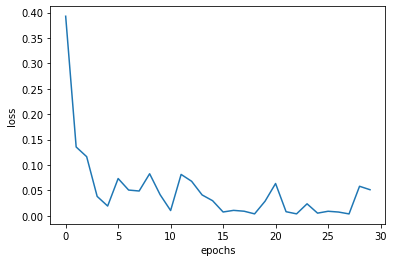

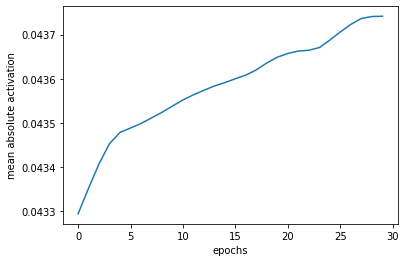

In [23]:
simple_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics="accuracy")
simple_model.fit(x_train, y_train_onehot, epochs=30, batch_size=batch_size, shuffle=True, callbacks=[simple_model_cb])

### Test the standalone gate network model

In [24]:
K.clear_session()

In [25]:
simple_gate_cb = SimpleGateCallback()

In [26]:
gate = gate_layers(input, 3, 'simple_gate_output')
gate_model = Model(input, gate, name='simple_gate_model' )

In [27]:
gate_model.summary()

Model: "simple_gate_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
myInput (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              5000      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               150300    
_________________________________________________________________
simple_gate_output (Dense)   (None, 3)                 903       
Total params: 656,703
Trainable params: 656,703
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
8/8 [==============================] - 0s 3ms/step - loss: 0.9265 - categorical_accuracy: 0.5750
Epoch 2/30
8/8 [==============================] - 0s 3ms/step - loss: 0.4695 - categorical_accuracy: 0.8583
Epoch 3/30
8/8 [==============================] - 0s 3ms/step - loss: 0.3009 - categorical_accuracy: 0.9000
Epoch 4/30
8/8 [==============================] - 0s 4ms/step - loss: 0.2260 - categorical_accuracy: 0.9250
Epoch 5/30
8/8 [==============================] - 0s 4ms/step - loss: 0.1495 - categorical_accuracy: 0.9667
Epoch 6/30
8/8 [==============================] - 0s 4ms/step - loss: 0.1418 - categorical_accuracy: 0.9583
Epoch 7/30
8/8 [==============================] - 0s 4ms/step - loss: 0.1974 - categorical_accuracy: 0.9083
Epoch 8/30
8/8 [==============================] - 0s 3ms/step - loss: 0.1320 - categorical_accuracy: 0.9500
Epoch 9/30
8/8 [==============================] - 0s 4ms/step - loss: 0.1496 - categorical_accuracy: 0.9333
Epoch 10/30
8/8 [===========

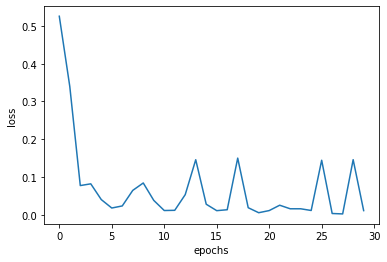

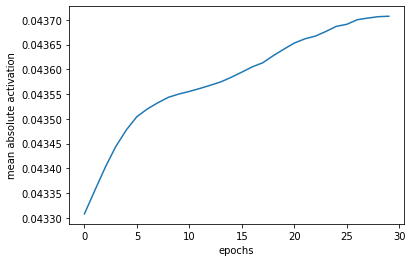

In [28]:
gate_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["categorical_accuracy"])
gate_model.fit(x_train, y_train_onehot, epochs=30, batch_size=batch_size, shuffle=True, callbacks=[simple_gate_cb])

### Mixture of experts model

In [29]:
K.clear_session()

In [30]:
num_experts = 3

In [31]:
#Initialize gate network
gate = gate_layers(input, num_experts, 'gate_layer')

In [32]:
#Initialize expert networks
experts = []
for i in range(num_experts):
    experts.append(expert_layers(input, 3, 'expert_'+str(i)))

In [33]:
# Initialize the selector network
expert_output = experts[0]
if num_experts > 1:
    expert_output = tf.keras.layers.Concatenate(axis=0)(experts)
selector_output = selector_expectation(num_experts=num_experts, trainable=False)([expert_output, gate])

In [34]:
selector_model = CustomModel(input, selector_output,name='selector')

In [35]:
selector_model.summary()

Model: "selector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
myInput (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
___________________________________________________________________________________________

In [36]:
selector_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics="accuracy")

In [37]:
analysis_cb = AnalysisCallback(num_experts)

Epoch 1/30

 gate gradients: [0.000188274251, 1.44935821e-05, 2.06604891e-05, 0.000236141583]
1/8 [==>...........................] - ETA: 0s - loss: 1.1502 - accuracy: 0.2000
 gate gradients: [0.00076461985, 4.3455555e-05, 6.67999702e-05, 0.000734059431]

 gate gradients: [0.000897470221, 5.35560102e-05, 9.43176783e-05, 0.00137406052]

 gate gradients: [0.00290902704, 0.000178492468, 0.000317076046, 0.00465571973]

 gate gradients: [0.000637849502, 3.51153467e-05, 5.163065e-05, 0.000712020381]
5/8 [=================>............] - ETA: 0s - loss: 1.1949 - accuracy: 0.4400
 gate gradients: [0.000672278868, 3.78015757e-05, 6.8494177e-05, 0.00128402503]

 gate gradients: [0.00041846704, 2.28466615e-05, 4.41419033e-05, 0.000719000644]

 gate gradients: [0.000511210063, 2.6403115e-05, 4.56394118e-05, 0.00104286836]
8/8 [==============================] - 0s 16ms/step - loss: 1.2160 - accuracy: 0.4000
Epoch 2/30

 gate gradients: [0.000250262121, 1.31618481e-05, 2.39338406e-05, 0.00050987728

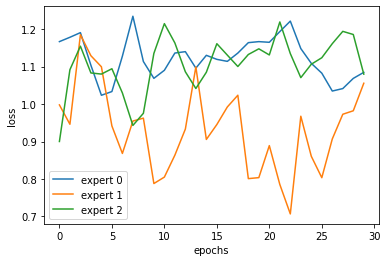

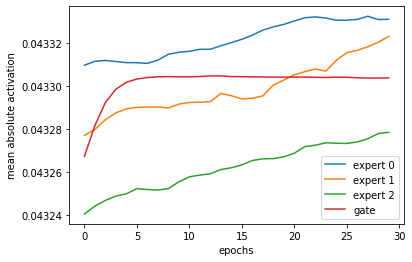

In [38]:
selector_model.fit(x_train, y_train_onehot, epochs=30, batch_size=batch_size, shuffle=True, callbacks=[analysis_cb])

### Comparing activations of standalone expert network to an expert of MOE

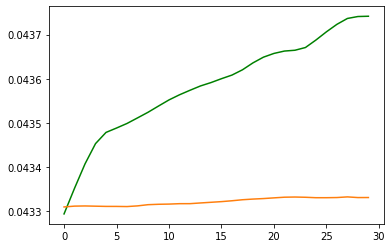

In [39]:
plt.plot(range(len( simple_model_cb.simple_model_mean_abs_act)), simple_model_cb.simple_model_mean_abs_act,color='g')
plt.plot(range(len( analysis_cb.expert_mean_abs_act_0)), analysis_cb.expert_mean_abs_act_0, color='tab:orange')
plt.show()

### Comparing predictions of standalone expert network with the predictions of the MOE network

In [40]:
pred = simple_model.predict(x_test, batch_size=batch_size)
pred

array([[9.99997020e-01, 3.03512616e-06, 1.94109817e-09],
       [9.99599636e-01, 3.99664044e-04, 6.69898441e-07],
       [9.99988198e-01, 1.18233911e-05, 1.64533702e-08],
       [9.99972939e-01, 2.70762212e-05, 2.31700650e-08],
       [9.99983430e-01, 1.65885613e-05, 1.11336389e-08],
       [9.99968767e-01, 3.12487246e-05, 3.10381587e-08],
       [9.99997497e-01, 2.50431822e-06, 1.32650479e-09],
       [9.99985933e-01, 1.40824177e-05, 1.58600280e-08],
       [9.99998093e-01, 1.85432918e-06, 7.69715180e-10],
       [9.99993443e-01, 6.58564568e-06, 4.36493197e-09],
       [5.22133196e-04, 5.95585287e-01, 4.03892606e-01],
       [4.60675306e-04, 8.92861903e-01, 1.06677406e-01],
       [1.21866760e-03, 9.88120675e-01, 1.06606307e-02],
       [4.90281451e-03, 9.89575386e-01, 5.52182132e-03],
       [8.62961693e-04, 8.89406741e-01, 1.09730303e-01],
       [1.24778948e-03, 9.87509847e-01, 1.12423114e-02],
       [9.85250343e-04, 9.71183956e-01, 2.78308820e-02],
       [7.70124141e-04, 9.91179

In [41]:
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [42]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=float32)

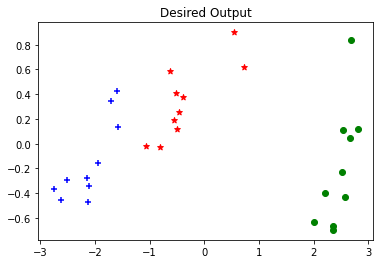

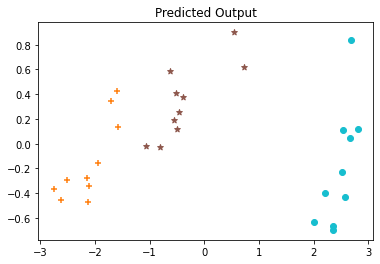

In [43]:
# PCA projection of actual and predicted targets with standalone expert
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(x_test)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y_test == i,0], coord[y_test == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()
for i in range(3):
    plt.scatter(coord[pred == i,0], coord[pred == i, 1],color=colors1[i], marker=markers[i])
plt.title('Predicted Output')
plt.show()

In [44]:
pred = selector_model.predict(x_test, batch_size=batch_size)
pred

array([[0.34102064, 0.32951123, 0.3294682 ],
       [0.34205532, 0.32929146, 0.3286533 ],
       [0.34162807, 0.32930097, 0.32907093],
       [0.34155193, 0.3306425 , 0.32780558],
       [0.34062675, 0.33045086, 0.32892242],
       [0.35182264, 0.31013185, 0.33804554],
       [0.3661965 , 0.29838836, 0.33541518],
       [0.37048587, 0.29826945, 0.33124474],
       [0.2846838 , 0.30638275, 0.40893346],
       [0.29510745, 0.31160933, 0.39328316],
       [0.34231597, 0.32941473, 0.3282694 ],
       [0.34618017, 0.32736936, 0.32645047],
       [0.3423619 , 0.3271942 , 0.33044383],
       [0.34646487, 0.3323909 , 0.3211444 ],
       [0.34377456, 0.3327093 , 0.3235162 ],
       [0.3416194 , 0.33071724, 0.3276634 ],
       [0.34154513, 0.33075443, 0.3277005 ],
       [0.34246358, 0.33111745, 0.32641888],
       [0.34297365, 0.33163688, 0.32538947],
       [0.34312257, 0.33129492, 0.3255824 ],
       [0.28640294, 0.30564207, 0.40795502],
       [0.28704822, 0.30602518, 0.4069267 ],
       [0.

In [45]:
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 0, 0, 0, 0, 0])

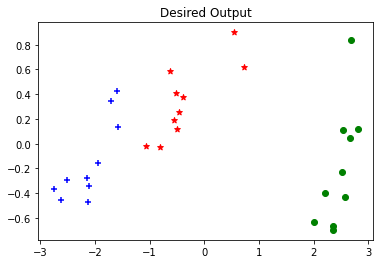

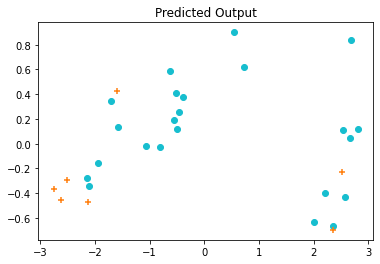

In [46]:
# PCA projection of actual and predicted targets with MOE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(x_test)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y_test == i,0], coord[y_test == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()
for i in range(3):
    plt.scatter(coord[pred == i,0], coord[pred == i, 1],color=colors1[i], marker=markers[i])
plt.title('Predicted Output')
plt.show()

### Mixture of Experts model with the gate output fixed at [1,0,0]

In [79]:
K.clear_session()

In [80]:
#Gate network (Similar to the expert layer) with a fixed output of [1, 0, 0]
def gate_layers_fixed(input, output, name):
    x = layers.Dense(1000, activation='relu', kernel_initializer=initializers.Zeros(), 
                     bias_initializer=initializers.Zeros())(input)
    x = layers.Dense(500, activation='relu', kernel_initializer=initializers.Zeros(), 
                     bias_initializer=initializers.Zeros())(x)
    x = layers.Dense(300,activation='relu', kernel_initializer=initializers.Zeros(), 
                     bias_initializer=initializers.Zeros())(x)
    x = layers.Dense(output, activation='softmax',name=name, kernel_initializer=initializers.Zeros(), 
                     bias_initializer=tf.constant_initializer([3.]+[0.]*(output-1)))(x)
    return x

In [81]:
num_experts = 3

In [82]:
#Initialize gate network
gate = gate_layers_fixed(input, num_experts, 'gate_layer')

In [83]:
#Initialize expert networks
experts = []
for i in range(num_experts):
    experts.append(expert_layers(input, 3, 'expert_'+str(i)))

In [84]:
# Initialize the selector network
expert_output = experts[0]
if num_experts > 1:
    expert_output = tf.keras.layers.Concatenate(axis=0)(experts)
selector_output = selector_expectation(num_experts=num_experts, trainable=False)([expert_output, gate])

In [85]:
selector_model = CustomModel(input, selector_output,name='selector')

In [86]:
selector_model.summary()

Model: "selector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
myInput (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
___________________________________________________________________________________________

In [87]:
selector_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics="accuracy")

In [88]:
analysis_cb = AnalysisCallback(num_experts)

Epoch 1/30

 gate gradients: [0, 0, 0, 0]
1/8 [==>...........................] - ETA: 0s - loss: 1.1979 - accuracy: 0.1333
 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]
4/8 [==============>...............] - ETA: 0s - loss: 1.2535 - accuracy: 0.2500
 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]
8/8 [==============================] - 0s 16ms/step - loss: 1.2731 - accuracy: 0.2917
Epoch 2/30

 gate gradients: [0, 0, 0, 0]
1/8 [==>...........................] - ETA: 0s - loss: 1.2847 - accuracy: 0.2000
 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]
5/8 [=================>............] - ETA: 0s - loss: 1.1441 - accuracy: 0.3600
 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]
8/8 [==============================] - 0s 13ms/step - loss: 1.1594 - accurac

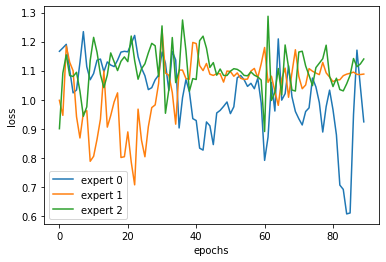

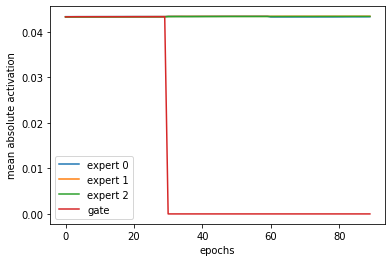

In [89]:
selector_model.fit(x_train, y_train_onehot, epochs=30, batch_size=batch_size, shuffle=True, callbacks=[analysis_cb])

In [90]:
pred = selector_model.predict(x_test, batch_size=batch_size)
pred

array([[0.4553249 , 0.27840206, 0.266273  ],
       [0.4472153 , 0.28327906, 0.26950556],
       [0.45905435, 0.27722865, 0.26371694],
       [0.44567987, 0.2819446 , 0.27237555],
       [0.36940053, 0.309105  , 0.32149434],
       [0.33618373, 0.33792207, 0.3258941 ],
       [0.33644146, 0.33794904, 0.32560945],
       [0.33640164, 0.33786625, 0.32573196],
       [0.33629075, 0.33791882, 0.32579038],
       [0.3368479 , 0.33788076, 0.3252713 ],
       [0.31841072, 0.32915884, 0.35243034],
       [0.31803787, 0.32816845, 0.35379362],
       [0.3174948 , 0.32868946, 0.35381562],
       [0.31790552, 0.32821986, 0.3538745 ],
       [0.3135901 , 0.32217172, 0.36423802],
       [0.3696612 , 0.30884305, 0.32149562],
       [0.3750176 , 0.30846578, 0.3165165 ],
       [0.35625792, 0.30574405, 0.33799794],
       [0.3469077 , 0.30607724, 0.347015  ],
       [0.35350114, 0.30734304, 0.33915576],
       [0.33681518, 0.33786628, 0.32531846],
       [0.3365052 , 0.33777162, 0.32572305],
       [0.

In [91]:
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2])

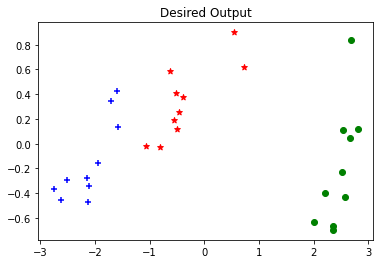

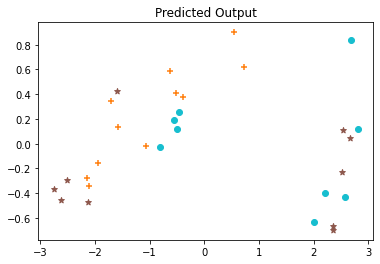

In [92]:
# PCA projection of actual and predicted targets with MOE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(x_test)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y_test == i,0], coord[y_test == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()
for i in range(3):
    plt.scatter(coord[pred == i,0], coord[pred == i, 1],color=colors1[i], marker=markers[i])
plt.title('Predicted Output')
plt.show()